<a href="https://colab.research.google.com/github/legenduck/legenduck.github.io/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Attention(nn.Module):
    """
    Scaled Dot Product Attention mechanism.

    Args:
        query: query tensor.
        key: key tensor.
        value: value tensor.
        mask (선택사항): mask tensor로 attention에 mask를 적용. 기본값은 None.
        dropout (선택사항): attention 가중치에 dropout을 적용할 레이어. 기본값은 None.

    Returns:
        tuple: attention된 value tensor와 attention 가중치 tensor를 포함하는 tuple.
    """
    def forward(self, query, key, value, mask=None, dropout=None):
        # 점수 계산
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))

        # 마스크가 제공된 경우 적용
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 소프트맥스를 적용하여 어텐션 가중치를 얻음.
        p_attn = F.softmax(scores, dim=1)

        # 드롭아웃이 제공된 경우 적용
        if dropout is not None:
            p_attn = dropout(p_attn)

        # 어텐션 가중치를 사용하여 어텐션된 값을 계산.
        attended_value = torch.matmul(p_attn, value)

        return attended_value, p_attn


In [ ]:
import torch.nn as nn
from .single import Attention

"""
multi_head.py
"""

class MultiHeadAttention(nn.Module):
    """
    Multi Head Attention 모듈.

    Args:
        h (int): Head 수.
        d_model (int): 모델의 차원.
        dropout (float, optional): 드롭아웃 확률. 기본값은 0.1.

    Attributes:
        d_k (int): Head당 차원.
        h (int): Head 수.
        linear_layers (ModuleList): linear 레이어의 리스트.
        output_linear (Linear): output linear 레이어.
        attention (Attention): attention 모듈.
        dropout (Dropout): 드롭아웃 레이어.
    """
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        # 각각 query, key, value에 대한 linear 레이어
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()
        self.dropout = nn.Dropout(p=dropout)
    """
      Args:
        query: query tensor.
        key: key tensor.
        value: value tensor.
        mask (선택사항): mask tensor로 attention에 mask를 적용. 기본값은 None.
    """
    def forward(self, query, key, value, mask=None):
        batch_size = query.size()
        # 각각 query, key, value에 대한 linear 레이어 적용 후 Head 수에 맞게 형태 변환
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for l, x in
                              zip(self.linear_layers, (query, key, value))]

        # attention 모듈 적용
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # Head 차원을 다시 합치고 output linear 레이어를 통과시킴
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


In [ ]:
import torch.nn as nn

from .attention import MultiHeadedAttention
from .utils import SublayerConnection, PositionwiseFeedForward

"""
transformer.py
"""

class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
      Args:
        hidden: 트랜스포머의 hidden state 크기
        attn_heads: 멀티헤드 어텐션의 헤드 크기
        feed_forward_hidden: feed forward의 hidden 크기
        dropout: 드롭아웃 비율
        """

        super().__init__()
        # 멀티헤드 어텐션
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        # 포지션 와이즈 피드 포워드
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        # 입력 서브레이어 커넥션
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        # 출력 서브레이어 커넥션
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        # 입력 서브레이어 커넥션을 통한 어텐션 적용
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        # 출력 서브레이어 커넥션을 통한 피드 포워드 적용
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


BERT는 아래 세가지의 임베딩을 수행한다.

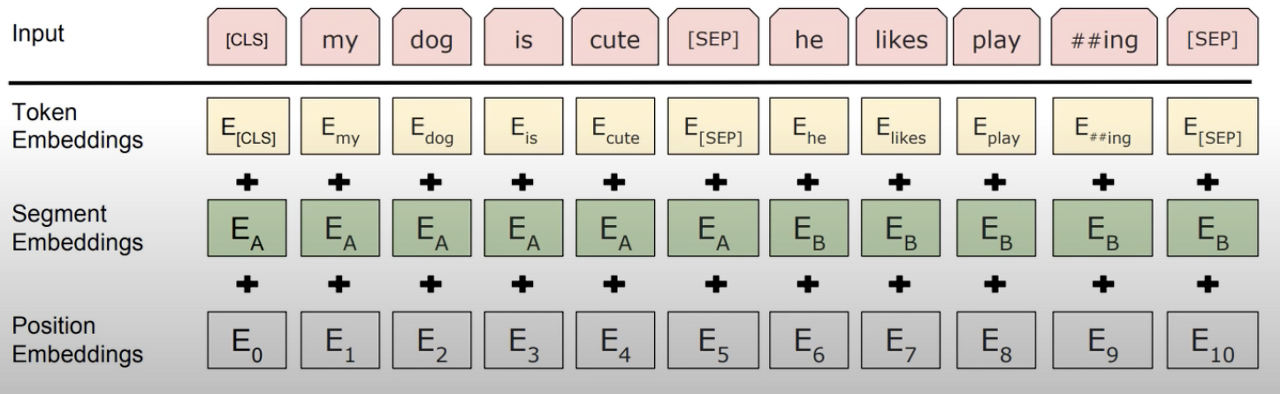

In [ ]:
import torch.nn as nn

"""
segment.py
"""

class TokenEmbedding(nn.Embedding) :
    def __init__(self, vocab_size, embed_size = 512) :
        super().__init__(vocab_size, embed_size, padding_idx = 0)


In [ ]:
import torch.nn as nn

"""
segment.py
"""

class SegmentEmbedding(nn.Embedding) :

    def __init__(self, embed_size = 512) :
        super().__init__(3, embed_size, padding_idx = 0)

In [ ]:
import torch.nn as nn
import torch
import math

"""
position.py
"""

class PositionalEmbedding(nn.Module) :

    def __init__(self, d_model, max_len = 512) :
        super().__init__()

        # compute positional encoding in log space
        pe = torch.zeros(max_len, d_model).float()
        pe.required_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x) :
        return self.pe[:, :x.size(1)]

In [ ]:
#위 세가지 임베딩을 최종적으로 모델에 입력할 수 있는 형태로 전달하는 class

import torch.nn as nn
from .token import TokenEmbedding
from .position import PositionalEmbedding
from .segment import SegmentEmbedding

"""
bert.py
"""

class BERTEmbedding(nn.Module):

    def __init__(self, vocab_size, embed_size, dropout=0.1):

        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

In [ ]:
import torch.nn as nn

from .transformer import TransformerBlock
from .embedding import BERTEmbedding

"""
bert.py
"""

class BERT(nn.Module) :

    def __init__(self, vocab_size, hidden = 768, n_layers = 12, attn_heads = 12, dropout = 0.1) :
        super().__init__()
        self.hidden = hidden
        self.n_layer = n_layers
        self.attn_heads = attn_heads

        # paper : use 4*hidden_size for ff network hidden size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT = token + segment + position
        self.embedding = BERTEmbedding(vocab_size = vocab_size, embed_size = hidden)

        # transformer block
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)]
        )

    def forward(self, x, segment_info) :
        # attention masking
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # run multiple transformer block
        for transformer in self.transformer_blocks :
            x = transformer.forward(x, mask)

        return x

pre-training 단계에서 학습을 진행하는 language model로 Masked Language Model(MLM), Next Sentence Prediction(NSP)를 정의

In [ ]:
"""
language_model.py
"""

class MaskedLanguageModel(nn.Module) :
    def __init__(self, hidden, vocab_size) :
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim = -1)

    def forward(self, x) :
        return self.softmax(self.linear(x))

In [ ]:
"""
language_model.py
"""

class NextSentencePrediction(nn.Module) :

    def __init__(self, hidden) :
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmaz = nn.LogSoftmax(dim = -1)

    def forward(self, x) :
        return self.softmax(self.linear(x[:, 0]))

language model로 위 두 학습을 진행하는 전체 코드는 다음과 같다.

In [ ]:
"""
language_model.py
"""

class BERTLTM(nn.Module) :

    def __init__(self, bert : BERT, vocab_size) :
        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.hidden)
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x, segment_label) :
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm